# NT1 - Data Oganizer for geotechnical data analysis and plotting

## Query Data Organizer for E, sigma_c, tau, then write to lists and show report tables 

In [658]:
# Notes of data preparation!
# -data preparation in lab spreadsheet
# -csv export a) check number formats, etc; b) check missing data fields (make sure they are blank and not string!)
# -csv import into couchbase (reference csv inoporting notebook)

In [659]:
# Explanation of testing and of data analysis
# - aim is to provide short, concise text that can be used for a geotechnical factual report

In [660]:
# open Data Organizer
from DataOrganizer import CouchbaseSelector
db = CouchbaseSelector('localhost','geotechnical')

In [661]:
# set up python ecosystem
import json
from math import *
import pandas as pd
import numpy as np
from IPython.core.display import HTML, display
#import tabulate
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm
from scipy import stats

In [662]:
# Notes:
# - To rerun analysis, best to choose Cell --> Run All
#   Rerunning an individual cell can give unexpected results. Unclear why                                 #ToDo JK

In [663]:
# define functions that are frequently reused here



In [664]:
# query Data Organizer records for 'parameter' = E 
# sorting by borehole_code and sample_depth

# initialize variables
data_E=[]

parameter = 'E'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_type']
selector = {'project_code': 'NT1', 'data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write rec to data_E if measurement_convention is E50 or is blank (assued to be E50)
# if value for E is blank, replace with 'NaN'    
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    if rec['measurement_convention'] != 'Es':
      data_E.append(rec)

print('count for E: '+str(len(data_E)))    # record count for checking

count for E: 54


In [665]:
# write returned Data Organizer list to a pandas data frame and display as html
data_E_df = pd.DataFrame(data=data_E)
data_E_df.columns = [u'Borehole', u'Lithology', u'Measurement', u'Depth', u'Sample', u'Test', u'Value', u'Unit']
display(HTML('<h4>Laboratory Testing Data - E measured during compressive testing</h3>'))
display(HTML(data_E_df.to_html()))                                                             
##display(HTML(data_E_df.to_html(formatters={'value':lambda x: u'{:06.2f}'.format(float(x))})))
# order columns of report tables to something more suitable                                             #ToDo JK

,Borehole,Lithology,Measurement,Depth,Sample,Test,Value,Unit
0,NT1-1,Conglomerate,,27.10,Basic Design,E measured during uniaxial compression,3352.00,MPa
1,NT1-1,Conglomerate,,61.50,Basic Design,E measured during uniaxial compression,3532.00,MPa
2,NT1-11,Sandstone,,15.65,Basic Design,E measured during uniaxial compression,3142.00,MPa
3,NT1-14,Red Sandstone,E50,28.90,Construction Design,E measured during uniaxial compression,13200.00,MPa
4,NT1-14,Red Sandstone,E50,36.80,Construction Design,E measured during uniaxial compression,51400.00,MPa
5,NT1-14,Red Sandstone,E50,37.30,Construction Design,E measured during uniaxial compression,19700.00,MPa
6,NT1-14,Red Sandstone,E50,37.30,Construction Design,E measured during uniaxial compression,17800.00,MPa
7,NT1-14,Red Sandstone,E50,56.80,Construction Design,E measured during uniaxial compression,22100.00,MPa
8,NT1-15,Siltstone,E50,32.20,Construction Design,E measured during uniaxial compression,4170.00,MPa
9,NT1-15,Siltstone,E50,36.08,Construction Design,E measured during triaxial compression,6867.00,MPa


In [666]:
# query Data Organizer records for 'parameter' = sigma_c
# sorting by borehole_code and sample_depth

# initialize variables
data_sigma_c=[]

parameter = 'sigma_c'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']
    #print rec['test_parameters'][0]['value']

    data_sigma_c.append(rec)
    
print('count for sigma_c: '+str(len(data_sigma_c)))    # record count for checking

count for sigma_c: 60


In [667]:
# write returned Data Organizer list to a pandas data frame and display as html
data_sigma_c_df = pd.DataFrame(data=data_sigma_c)
data_sigma_c_df.columns = [u'Borehole',u'Lithology',u'Depth',u'Sample',u's3',u'Test',u'Value',u'Unit']
display(HTML('<h4>Laboratory Testing Data - sigma_c from compressive testing</h4>'))
display(HTML(data_sigma_c_df.to_html()))

,Borehole,Lithology,Depth,Sample,s3,Test,Value,Unit
0,NT1-1,Conglomerate,27.10,Basic Design,,Uniaxial compression,86.82,MPa
1,NT1-1,Conglomerate,61.50,Basic Design,,Uniaxial compression,75.15,MPa
2,NT1-11,Sandstone,15.65,Basic Design,,Uniaxial compression,85.02,MPa
3,NT1-14,Red Sandstone,28.90,Construction Design,3.00,Triaxial compression,127.17,MPa
4,NT1-14,Red Sandstone,28.90,Construction Design,5.00,Triaxial compression,128.55,MPa
5,NT1-14,Red Sandstone,28.90,Construction Design,,Uniaxial compression,56.01,MPa
6,NT1-14,Red Sandstone,28.90,Construction Design,1.00,Triaxial compression,90.54,MPa
7,NT1-14,Red Sandstone,36.80,Construction Design,,Uniaxial compression,106.68,MPa
8,NT1-14,Red Sandstone,37.30,Construction Design,,Uniaxial compression,78.68,MPa
9,NT1-14,Red Sandstone,37.30,Construction Design,,Uniaxial compression,126.68,MPa


In [668]:
# query Data Organizer records for 'parameter' = tau
# sorting by borehole_code and sample_depth

# initialize variables
data_tau=[]

parameter = 'tau'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3    #ToDo JK

    ##if rec['measurement_convention'] == 'Peak strength':  #tmp - should handled in plot data              #ToDo JK
    ##  data_tau.append(rec)
    data_tau.append(rec)
    
print('count for tau: '+str(len(data_tau)))    # record count for checking

count for tau: 54


In [669]:
# write returned Data Organizer list to a pandas data frame and display as html
data_tau_df = pd.DataFrame(data=data_tau)
data_tau_df.columns = [u'Borehole', u'Lithology', u'Measurement', u'Depth', u'Sample', u's3', u'Test', 
                       u'Value', u'Unit']
display(HTML('<h4> Laboratory Testing Data - tau measured during direct shear testing</h4>'))
display(HTML(data_tau_df.to_html()))

,Borehole,Lithology,Measurement,Depth,Sample,s3,Test,Value,Unit
0,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.40,Direct shear,0.23,MPa
1,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.20,Direct shear,0.16,MPa
2,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.40,Direct shear,0.25,MPa
3,Diversion Tunnel,Sheared Mudstone,Peak strength,,Construction Design,0.40,Direct shear,0.20,MPa
4,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.80,Direct shear,0.49,MPa
5,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.80,Direct shear,0.46,MPa
6,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.20,Direct shear,0.17,MPa
7,Diversion Tunnel,Sheared Mudstone,Peak strength,,Construction Design,0.80,Direct shear,0.34,MPa
8,Diversion Tunnel,Sheared Mudstone,Residual strength,,Construction Design,0.80,Direct shear,0.46,MPa
9,Diversion Tunnel,Sheared Mudstone,Peak strength,,Construction Design,0.40,Direct shear,0.18,MPa


## Plot histograms for E50 data

In [670]:
# prepare E values for histogram 
# input: data_E

data_E_sel=[]

# select testing results from Basic Design
for item in data_E:
    if (item['value']) != 'NaN':
        if (item['sample_description']) == 'Basic Design':
            data_E_sel.append(float(item['value']))
    
print('count for selected E: '+str(len(data_E_sel)))    # record count for checking

count for selected E: 21


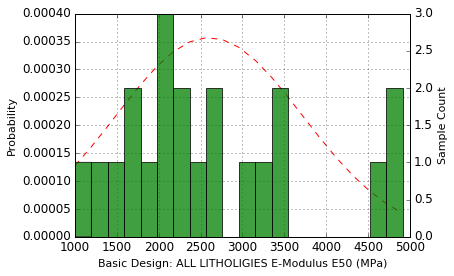

mean = 2603
standard deviation = 1117


In [671]:
# plot histogram of all E50 values
# input: data_e containing 'values' of 'parameter' E

# input: E containing 'values' of 'parameter' E
E = data_E_sel

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot histogram of E values for all rock lithologies
hist,bin_edges,patches = ax2.hist(E, 20, normed=0, facecolor='green', alpha=0.75)
ax2.set_ylabel('Sample Count',fontsize=11)

# plot distribution of E values using scipy
# param[0] and param[1] are the mean and the standard deviation of the fitted distribution
param = norm.fit(E) 
y = mlab.normpdf( bin_edges, param[0], param[1])
ll = ax1.plot(bin_edges, y, 'r--', linewidth=1)  #plot pdf
ax1.set_ylabel('Probability',fontsize=11)
# just guessing at distribution
#mu, sigma = 15000, 10000
#y = mlab.normpdf( bin_edges, mu, sigma)

# plot axis labels and grid
ax1.set_xlabel('Basic Design: ALL LITHOLIGIES E-Modulus E50 (MPa)',fontsize=11)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)  
ax1.grid(True)

plt.show()

print('mean = '+str(format(param[0],'.0f')))
print('standard deviation = '+str(format(param[1],'.0f')))

In [672]:
# prepare E values for histogram 
# input: data_E

data_E_sel=[]

# select testing results from Construction Design
for item in data_E:
    if (item['value']) != 'NaN':
        if (item['sample_description']) == 'Construction Design':
            data_E_sel.append(float(item['value']))

print('count for selected E: '+str(len(data_E_sel)))    # record count for checking

count for selected E: 29


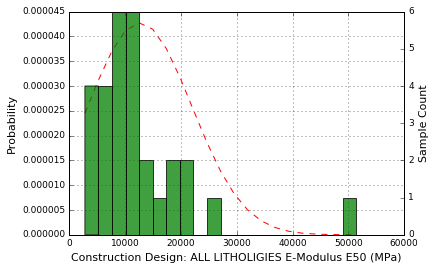

mean = 12629
standard deviation = 9334


In [673]:
# plot histogram of all E50 values
# input: data_e containing 'values' of 'parameter' E

# input: E containing 'values' of 'parameter' E
E = data_E_sel

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot histogram of E values for all rock lithologies
hist,bin_edges,patches = ax2.hist(E, 20, normed=0, facecolor='green', alpha=0.75)
ax2.set_ylabel('Sample Count',fontsize=11)

# plot distribution of E values using scipy
# param[0] and param[1] are the mean and the standard deviation of the fitted distribution
param = norm.fit(E) 
y = mlab.normpdf( bin_edges, param[0], param[1])
ll = ax1.plot(bin_edges, y, 'r--', linewidth=1)  #plot pdf
ax1.set_ylabel('Probability',fontsize=11)
# just guessing at distribution
#mu, sigma = 15000, 10000
#y = mlab.normpdf( bin_edges, mu, sigma)

# plot axis labels and grid
ax1.set_xlabel('Construction Design: ALL LITHOLIGIES E-Modulus E50 (MPa)',fontsize=11)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)  
ax1.grid(True)

plt.show()

print('mean = '+str(format(param[0],'.0f')))
print('standard deviation = '+str(format(param[1],'.0f')))

In [674]:
# prepare E values for selected lithologies 
# input: data_E

dict_E_basic={}
dict_E_const={}

def select_by_lithology(data, lithology, dict, sample_description):
  dict[lithology]=[]

  # select testing results from Construction Design
  for item in data:
    if (item['value']) != 'NaN':
      if (item['sample_description']) == sample_description:
        if (item['lithology']) == lithology:
            dict[lithology].append(float(item['value']))
        
select_by_lithology(data_E, 'Red Sandstone', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Sandstone', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Siltstone', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Mudstone', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Conglomerate', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Clay', dict_E_const, 'Construction Design')
select_by_lithology(data_E, 'Sheared Mudstone', dict_E_const, 'Construction Design')

select_by_lithology(data_E, 'Red Sandstone', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Sandstone', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Siltstone', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Mudstone', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Conglomerate', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Clay', dict_E_basic, 'Basic Design')
select_by_lithology(data_E, 'Sheared Mudstone', dict_E_basic, 'Basic Design')

#print(dict_E_const)
#print(dict_E_basic)

Red Sandstone:    mean = 24840  standard deviation = 13597
Siltstone:    mean = 10085  standard deviation = 5405


,Lithology,E - mean (MPa),E - standard deviation (MPa),E[95%CI]
0,Red Sandstone,24840,13597,-1810
1,Siltstone,10085,5405,-509


Sandstone:    mean = 3696  standard deviation = 896
Siltstone:    mean = 1877  standard deviation = 456
Conglomerate:    mean = 3926  standard deviation = 689


,Lithology,E - mean (MPa),E - standard deviation (MPa),E[95%CI]
0,Sandstone,3696,896,1939
1,Siltstone,1877,456,983
2,Conglomerate,3926,689,2576


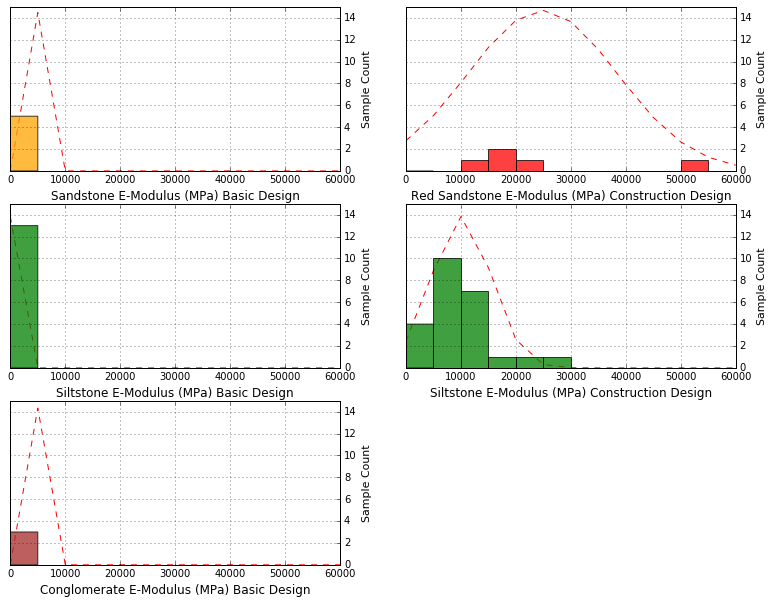

In [712]:
# plot histogram of all E values for selected lithologies 
# input: dict_E_const and dict_E_basic containing 'values' of 'parameter' E 

statistics=[]

# define dict for lithology colors
colors={'Red Sandstone':'red', 'Sandstone':'orange', 'Siltstone':'green', 'Conglomerate':'brown', 
        'Mudstone':'yellow' , 'Sheared Mudstone':'magenta', 'Clay':'black'}

def histogram_by_lithology(dict, lithology, sample_description):
  # plot histogram for values of selected lithology

    # plot histogram of E values for all rock lithologies
    ax2 = ax1.twinx()
    hist,bin_edges,patches = ax2.hist(dict[lithology],bins=[0,5000,10000,15000,20000,25000,30000,35000,40000,
                                                            45000,50000,55000,60000],
                                      normed=0,facecolor=colors[lithology],alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)
    ax2.set_ylim(0,15)
    ax2.set_xlim(0,60000)

    # plot distribution of E values using scipy
    # param[0] and param[1] are the mean and the standard deviation of the fitted distribution
    param = norm.fit(dict[lithology])
    y = mlab.normpdf( bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'r--', linewidth=1)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)
    # just guessing at distribution
    #mu, sigma = 15000, 10000
    #y = mlab.normpdf( bin_edges, mu, sigma)

    print(lithology+':    mean = '+str(format(param[0],'.0f'))
          +'  standard deviation = '+str(format(param[1],'.0f')))    

    statistics.append((lithology,
                        str(format(param[0],'.0f')),
                        str(format(param[1],'.0f')),
                        str(format(param[0]-param[1]*1.96,'.0f'))))
        
    # plot axis labels and grid
    ax1.set_xlabel(lithology+' E-Modulus (MPa) '+sample_description,fontsize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)  
    ax1.axes.get_yaxis().set_ticks([])  #supress pdf lables on left y-axis
    ax1.grid(True); ax2.grid(True)

# display derived parameters and statistics
def hist_statistics(project_phase):
    statistics_df = pd.DataFrame(data=statistics)
    statistics_df.columns = [u'Lithology', u'E - mean (MPa)', u'E - standard deviation (MPa)',
                             u'E[95%CI]']
    display(HTML('<h4>Statistics of E values - '
                 +project_phase+'</h3>'))
    display(HTML(statistics_df.to_html()))
  
    
fig = plt.figure(figsize=(13,10))
ax1 = fig.add_subplot(3, 2, 2)
histogram_by_lithology(dict_E_const, 'Red Sandstone', 'Construction Design')
ax1 = fig.add_subplot(3, 2, 4)
histogram_by_lithology(dict_E_const, 'Siltstone', 'Construction Design')
ax1 = fig.add_subplot(3, 2, 1)
hist_statistics('Construction Design')
statistics=[]
histogram_by_lithology(dict_E_basic, 'Sandstone', 'Basic Design')
ax1 = fig.add_subplot(3, 2, 3)
histogram_by_lithology(dict_E_basic, 'Siltstone', 'Basic Design')
ax1 = fig.add_subplot(3, 2, 5)
histogram_by_lithology(dict_E_basic, 'Conglomerate', 'Basic Design')
hist_statistics('Basic Design')
plt.show()
##fig.canvas.draw()

In [676]:
# prepare sigma_c (uniaxial compression) values for a selected lithologies
# input: data_sigma_c

dict_sigma_c_basic={}
dict_sigma_c_const={}

# select sigma_c data from uniaxial compression testing
data_sigma_c_sel=[]

# select testing results for Uniaxial compression
for item in data_sigma_c:
    if (item['test_type']) == 'Uniaxial compression':
        data_sigma_c_sel.append(item)
print(len(data_sigma_c_sel))

select_by_lithology(data_sigma_c_sel, 'Red Sandstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Sandstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Siltstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Mudstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Conglomerate', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Clay', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Sheared Mudstone', dict_sigma_c_const, 'Construction Design')

select_by_lithology(data_sigma_c_sel, 'Red Sandstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Sandstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Siltstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Mudstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Conglomerate', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Clay', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Sheared Mudstone', dict_sigma_c_basic, 'Basic Design')

print(dict_sigma_c_const)
print(dict_sigma_c_basic)
print(len(dict_sigma_c_const['Red Sandstone']))
print(len(dict_sigma_c_const['Siltstone']))
print(len(dict_sigma_c_basic['Sandstone']))
print(len(dict_sigma_c_basic['Siltstone']))
print(len(dict_sigma_c_basic['Conglomerate']))

39
{'Sheared Mudstone': [], 'Sandstone': [], 'Red Sandstone': [56.01, 106.68, 78.68, 126.68, 105.35], 'Siltstone': [20.67, 22.04, 19.98, 36.06, 19.29, 8.46, 9.77, 28.93, 28.93, 47.41, 45.9, 50.75, 46.33, 40.88, 39.38, 56.97, 24.67, 19.13, 15.3], 'Conglomerate': [], 'Mudstone': [], 'Clay': []}
{'Sheared Mudstone': [], 'Sandstone': [85.02, 83.3, 56.94, 58.69, 122.15, 118.97], 'Red Sandstone': [], 'Siltstone': [44.02, 53.64, 19.97, 29.78, 7.0, 25.6], 'Conglomerate': [86.82, 75.15, 113.55], 'Mudstone': [], 'Clay': []}
5
19
6
6
3


Red Sandstone:    mean = 95  standard deviation = 25
Siltstone:    mean = 31  standard deviation = 14


,Lithology,sigma_c - mean (MPa),sigma_c - standard deviation (MPa),sigma_c[95%CI]
0,Red Sandstone,95,25,46
1,Siltstone,31,14,3


Sandstone:    mean = 88  standard deviation = 26
Siltstone:    mean = 30  standard deviation = 15
Conglomerate:    mean = 92  standard deviation = 16


,Lithology,sigma_c - mean (MPa),sigma_c - standard deviation (MPa),sigma_c[95%CI]
0,Sandstone,88,26,37
1,Siltstone,30,15,0
2,Conglomerate,92,16,60


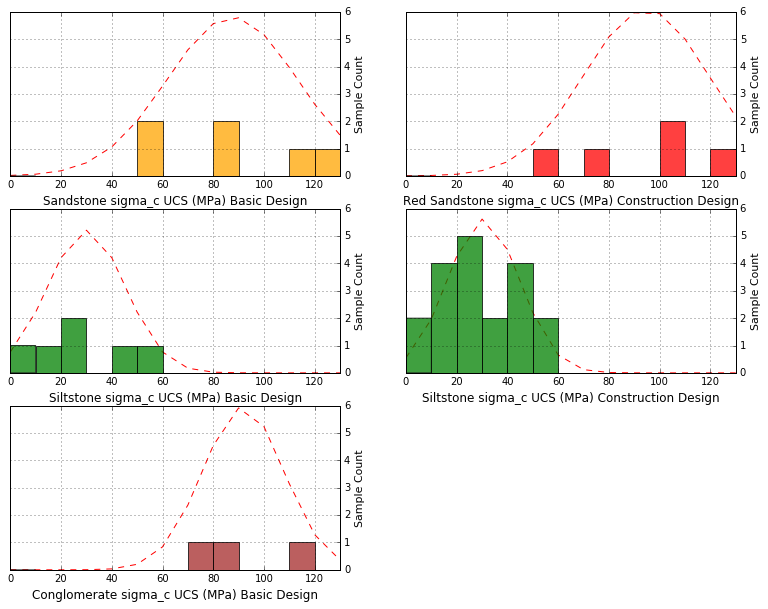

In [711]:
# plot histogram of all sigma_c values for selected lithologies 
# input: dict_sigma_c_const, dict_sigma_c_basic containing 'values' of 'parameter' sigma_c

statistics=[]

def histogram_by_lithology(dict, lithology, sample_description):
  # plot histogram for values of selected lithology
  # consider using two vertical axes, one for PDF and one (count) for histograms                          #ToDo JK
  n, bins, patches = plt.hist(dict[lithology], 10, normed=1, facecolor=colors[lithology], alpha=0.75)

  # plot fitted distribution of data using scipy
  param = norm.fit(dict[lithology]) 
  y = mlab.normpdf( bins, param[0], param[1])
  plt.plot(bins, y, 'r--', linewidth=1)

  plt.ylabel('Probability',fontsize=11)
  plt.xlabel(lithology+' sigma_c UCS (MPa) '+sample_description,fontsize=11)
  plt.rc('xtick', labelsize=9)
  plt.rc('ytick', labelsize=9)  
  plt.grid(True)

    
def histogram_by_lithology(dict, lithology, sample_description):
    # plot histogram for values of selected lithology 
    ax2 = ax1.twinx()
    hist,bin_edges,patches = ax2.hist(dict[lithology],bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130],
                                      normed=0,facecolor=colors[lithology],alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)
    ax2.set_ylim(0,6)
    ax2.set_xlim(0,130)

    # plot distribution of E values using scipy
    param = norm.fit(dict[lithology])
    y = mlab.normpdf( bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'r--', linewidth=1)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    print(lithology+':    mean = '+str(format(param[0],'.0f'))
          +'  standard deviation = '+str(format(param[1],'.0f')))    

    statistics.append((lithology,
                        str(format(param[0],'.0f')),
                        str(format(param[1],'.0f')),
                        str(format(param[0]-param[1]*1.96,'.0f'))))
    
    # plot axis labels and grid
    ax1.set_xlabel(lithology+' sigma_c UCS (MPa) '+sample_description,fontsize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)  
    ax1.axes.get_yaxis().set_ticks([])  #supress pdf lables on left y-axis
    ax1.grid(True); ax2.grid(True)

# display derived parameters and statistics
def hist_statistics(project_phase):
    statistics_df = pd.DataFrame(data=statistics)
    statistics_df.columns = [u'Lithology', u'sigma_c - mean (MPa)', u'sigma_c - standard deviation (MPa)',
                             u'sigma_c[95%CI]']
    display(HTML('<h4>Statistics of E values - '
                 +project_phase+'</h3>'))
    display(HTML(statistics_df.to_html()))

    
fig = plt.figure(figsize=(13,10))
ax1 = fig.add_subplot(3, 2, 2)
histogram_by_lithology(dict_sigma_c_const, 'Red Sandstone', 'Construction Design')
ax1 = fig.add_subplot(3, 2, 4)
histogram_by_lithology(dict_sigma_c_const, 'Siltstone', 'Construction Design')
ax1 = fig.add_subplot(3, 2, 1)
hist_statistics('Construction Design')
statistics=[]
histogram_by_lithology(dict_sigma_c_basic, 'Sandstone', 'Basic Design')
ax1 = fig.add_subplot(3, 2, 3)
histogram_by_lithology(dict_sigma_c_basic, 'Siltstone', 'Basic Design')
ax1 = fig.add_subplot(3, 2, 5)
histogram_by_lithology(dict_sigma_c_basic, 'Conglomerate', 'Basic Design')
hist_statistics('Basic Design')
plt.show()    

## p-q plot for sigma_c and tau data

In [678]:
# select sigma_c (uniaxial and triaxial compression) and tau (direct shear) values for selected lithologies
# sample_desciption is used to store construction phase (phase hould be added to parameter metadata)       #ToDo JK 

tests={'ucs':data_sigma_c,'tx':data_sigma_c,'ds':data_tau}  #test types and input data for each test type
test_names={'ucs':'Uniaxial compression','tx':'Triaxial compression','ds':'Direct shear'}  #for selecting test_type
lithologies=('Red Sandstone','Sandstone','Siltstone','Conglomerate','Mudstone','Sheared Mudstone','Clay')
sig1_const = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_const = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
sig1_basic = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
# Should all these not have to be in call to function?                                                     #ToDo JK

# select strength data from test results and write to dictionary
def selected_stengths(sample_description, sig1, sig3):
    for key,value in tests.items():  #loop over test types (=key)
        for lithology in lithologies:
            sig1[key][lithology]=[]  #initialize dictionary
            sig3[key][lithology]=[]  #initialize dictionary
        for rec in value:  #for each record of input data
            if (rec['test_type']) == test_names[key]: #select for test type 
                if (rec['value']) != 'NaN':  #ignore NaN values
                    if (rec['sample_description']) == sample_description:  #select for phase
                        for lithology in lithologies:  # select for lithology
                            if (rec['lithology']) == lithology:
                                sig1[key][lithology].append(float(rec['value']))
                                try: 
                                    float(rec['test_parameters']) 
                                    sig3[key][lithology].append(float(rec['test_parameters']))
                                except:
                                    sig3[key][lithology].append(float(0))  #set 'test_parameter' = 0 if missing
                                
selected_stengths('Construction Design', sig1_const, sig3_const) 
selected_stengths('Basic Design', sig1_basic, sig3_basic)            

def count_selected_stengths(sig1,description):  #counts for data checking
    for item in sig1: 
        count=0
        for lithology,value in sig1[item].items():
            item_len = len(sig1[item][lithology])
            count = count + item_len
            if item_len > 1:
                print(description+':   count for selected '+str(item)+' in '+str(lithology)+': '+str(item_len))
        print (description+': count for selected '+str(item)+': '+str(count)) 

count_selected_stengths(sig1_const,'Construction Design')
count_selected_stengths(sig1_basic,'Basic Design')

#print sig1_const['ucs']['Siltstone']
#print sig1_const['tx']
#print sig3_const['tx']

Construction Design:   count for selected ucs in Red Sandstone: 5
Construction Design:   count for selected ucs in Siltstone: 19
Construction Design: count for selected ucs: 24
Construction Design:   count for selected ds in Sheared Mudstone: 24
Construction Design:   count for selected ds in Sandstone: 6
Construction Design:   count for selected ds in Siltstone: 12
Construction Design:   count for selected ds in Clay: 12
Construction Design: count for selected ds: 54
Construction Design:   count for selected tx in Red Sandstone: 6
Construction Design:   count for selected tx in Siltstone: 6
Construction Design: count for selected tx: 12
Basic Design:   count for selected ucs in Sandstone: 6
Basic Design:   count for selected ucs in Siltstone: 6
Basic Design:   count for selected ucs in Conglomerate: 3
Basic Design: count for selected ucs: 15
Basic Design: count for selected ds: 0
Basic Design:   count for selected tx in Siltstone: 9
Basic Design: count for selected tx: 9


slope: 0.898880823841    intercept: 2.23586667553
phi: 64.0113442601    c: 5.10246797226
slope: 0.754217833511    intercept: 5.42848494433
phi: 48.9570726474    c: 8.2672618394


,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Red Sandstone,5.102,64.0,54.2,80.6,0.04,1.00,0.00004
1,Siltstone,8.267,49.0,36.7,65.6,0.08,0.98,0.00070


slope: 0.918231439538    intercept: -0.322472081028
phi: 66.6688847452    c: -0.81423251626


,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Siltstone,-0.814,66.7,58.8,78.9,0.03,1.00,0.00000


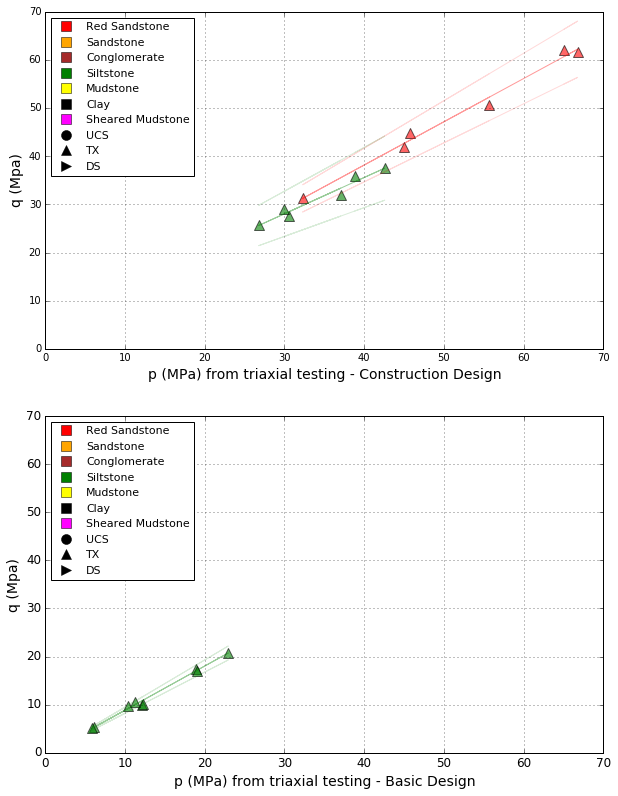

In [679]:
# p-q plot for sigma_c and tau data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'

statistics=[]

markers={'ucs':'o', 'tx':'^', 'ds':'>'} 

def legend():    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="magenta")
    sym10 = Line2D([0], [0], linestyle="none", marker="o", alpha=1.0, markersize=10, color="black")
    sym11 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym12 = Line2D([0], [0], linestyle="none", marker=">", alpha=1.0, markersize=10, color="black")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym10,sym11,sym12),
           ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone",
            "UCS","TX","DS"),fontsize=11, numpoints=1,loc="upper left")

def rand_jitter(arr):
    if not arr.any():
        pass
    else:
        stdev = .01*(max(arr)-min(arr))
        return arr + np.random.randn(len(arr)) * stdev

def pq_plot(sig1, sig3, lithology, test, sample_description):
# p-q plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    #statistics=[]
    #if test=='ucs' or test=='tx':
    if test=='ucs':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    if test=='tx':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept            
            line_upper = (slope+std_err*1.96)*s1+intercept
            line_lower = (slope-std_err*1.96)*s1+intercept
                                    
            #calculate c and phi from intercept and slope (a and alpha in p-q space) of trend lines
            print('slope: '+str(slope)+'    intercept: '+str(intercept))
            phi=asin(slope) #slope=tan(alpha)
            c=intercept/cos(phi)
            print('phi: '+str(degrees(phi))+'    c: '+str(c))
            
            statistics.append((lithology,
                              str(format(c,'.3f')),
                              str(format(degrees(phi),'.1f')),
                              str(format(degrees(asin(slope-std_err*1.96)),'.1f')),
                              str(format(degrees(asin(slope+std_err*1.96)),'.1f')),  #check for slope+std_err >1
                              str(format(std_err,'.2f')),                                               #ToDo JK
                              str(format(r_value,'.2f')),str(format(p_value,'.5f'))))
            
            plt.plot(s1,line, color=colors[lithology],alpha=0.4)
            plt.plot(s1,line_upper, color=colors[lithology],alpha=0.15)
            plt.plot(s1,line_lower, color=colors[lithology],alpha=0.15)            
            #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    if test=='ds':
        plt.scatter(rand_jitter(sig3_),rand_jitter(sig1_),
                    marker=markers[test],s= 150.,facecolor=colors[lithology],alpha=0.6)
        if not sig1_.any():  #if no data for lithology  --> mv this above plt.scatter                      #ToDo JK
            pass
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(sig3_,sig1_)
            line = slope*sig3_+intercept             
        plt.plot(sig3_,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    plt.ylabel('q (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('p (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

# display derived parameters and statistics
def plot_statistics(project_phase):
    statistics_df = pd.DataFrame(data=statistics)
    statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                             u'std_err', u'correlation', u'p_value']
    display(HTML('<h4>Derived c, phi and statistics of plotted p-q values from triaxial testing - '
                 +project_phase+'</h3>'))
    display(HTML(statistics_df.to_html()))
    

plt.figure(figsize=(10, 35))

#plt.subplot(511)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    pq_plot(sig1_const['ucs'], sig3_const['ucs'],lithology,'ucs','Construction Design')
##for lithology in lithologies:
##    pq_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
#legend()

plt.subplot(511)
plt.xlim((0,70))
plt.ylim((0,70))
for lithology in lithologies:
    pq_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
legend()
plot_statistics('Construction Design')

#plt.subplot(513)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    pq_plot(sig1_basic['ucs'], sig3_basic['ucs'],lithology,'ucs','Basic Design')
##for lithology in lithologies:
##    pq_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
#legend()

plt.subplot(512)
plt.xlim((0,70))
plt.ylim((0,70))
statistics=[]  #set list for HTML table to null
for lithology in lithologies:
    pq_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
legend()
plot_statistics('Basic Design')

#plt.subplot(515)
#plt.xlim((0,3))
#plt.ylim((0,3))
#for lithology in lithologies:
#    pq_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
#plt.ylabel('tau (Mpa)',fontsize=14)
#plt.xlabel('sigma_v (MPa) Construction Design',fontsize=14)
#legend()    

plt.show()

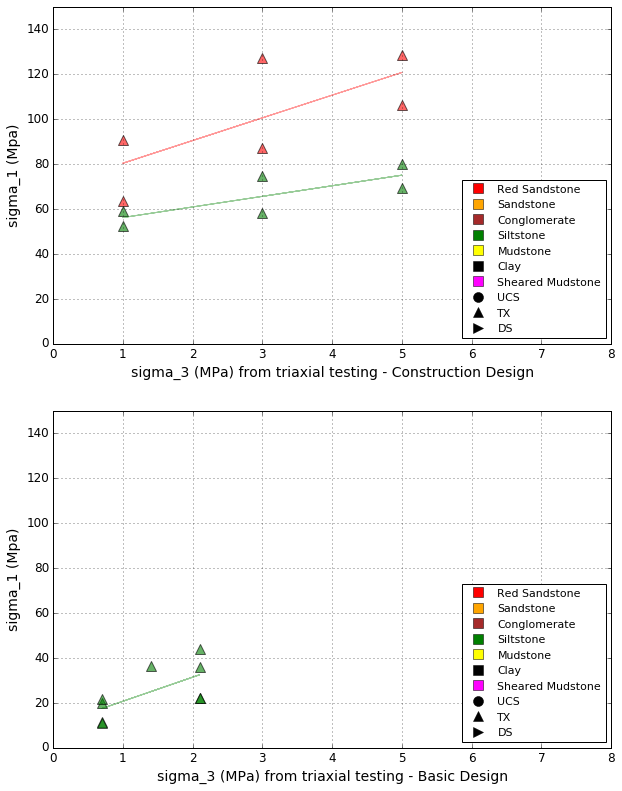

In [680]:
# sig1 vs sig3 plot for TX sigma_c data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'
# ADJUST: project phases, lithologies (above), plots: xlimit, ylimit, legend

markers={'ucs':'o', 'tx':'^', 'ds':'>'} 

def legend():    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="magenta")
    sym10 = Line2D([0], [0], linestyle="none", marker="o", alpha=1.0, markersize=10, color="black")
    sym11 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym12 = Line2D([0], [0], linestyle="none", marker=">", alpha=1.0, markersize=10, color="black")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym10,sym11,sym12),
           ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone",
            "UCS","TX","DS"),fontsize=11, numpoints=1,loc="lower right")

def rand_jitter(arr):
    if not arr.any():
        pass
    else:
        stdev = .01*(max(arr)-min(arr))
        return arr + np.random.randn(len(arr)) * stdev

def s1s3_plot(sig1, sig3, lithology, test, sample_description):
# sig1-sig3 plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.

    if test=='tx':
        plt.scatter(sig3_, sig1_,
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=sig1_
            s3=sig3_
            slope, intercept, r_value, p_value, std_err = stats.linregress(s3,s1)
            line = slope*s3+intercept
        plt.plot(s3,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    plt.ylabel('sigma_1 (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('sigma_3 (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

#plt.subplot(511)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    s1s3_plot(sig1_const['ucs'], sig3_const['ucs'],lithology,'ucs','Construction Design')
##for lithology in lithologies:
##    s1s3_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
#legend()

plt.subplot(511)
plt.xlim((0,8))
plt.ylim((0,150))
for lithology in lithologies:
    s1s3_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
legend()

#plt.subplot(513)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    s1s3_plot(sig1_basic['ucs'], sig3_basic['ucs'],lithology,'ucs','Basic Design')
##for lithology in lithologies:
##    s1s3_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
#legend()

plt.subplot(512)
plt.xlim((0,8))
plt.ylim((0,150))
for lithology in lithologies:
    s1s3_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
legend()

#plt.subplot(515)
#plt.xlim((0,3))
#plt.ylim((0,3))
#for lithology in lithologies:
#    s1s3_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
#plt.ylabel('tau (Mpa)',fontsize=14)
#plt.xlabel('sigma_v (MPa) Construction Design',fontsize=14)
#legend()    

plt.show()

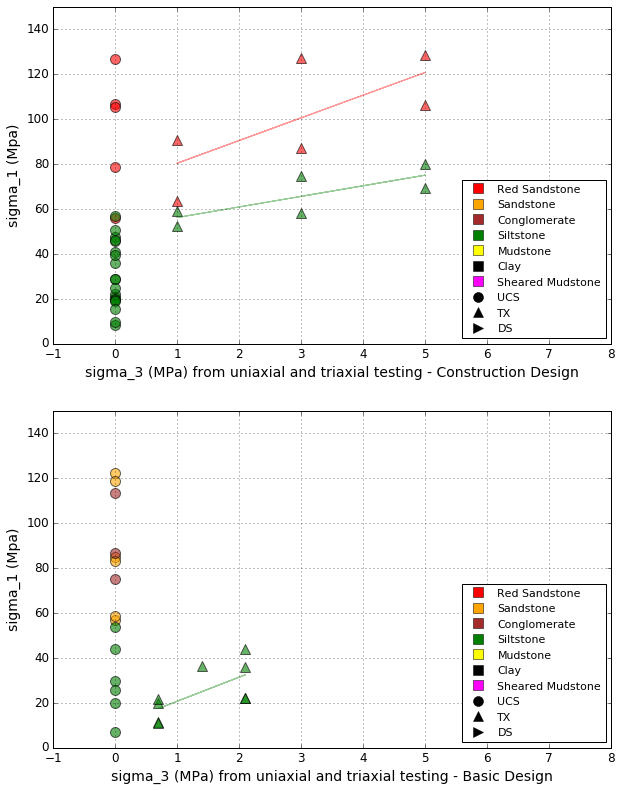

In [681]:
# sig1 vs sig3 plot for UCS and TX sigma_c data for all rock lithologies
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'
# ADJUST: project phases, lithologies (above), plots: xlimit, ylimit, legend

markers={'ucs':'o', 'tx':'^', 'ds':'>'} 

def legend():    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="magenta")
    sym10 = Line2D([0], [0], linestyle="none", marker="o", alpha=1.0, markersize=10, color="black")
    sym11 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym12 = Line2D([0], [0], linestyle="none", marker=">", alpha=1.0, markersize=10, color="black")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym10,sym11,sym12),
           ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone",
            "UCS","TX","DS"),fontsize=11, numpoints=1,loc="lower right")

def rand_jitter(arr):
    if not arr.any():
        pass
    else:
        stdev = .01*(max(arr)-min(arr))
        return arr + np.random.randn(len(arr)) * stdev

def s1s3_plot(sig1, sig3, lithology, test, sample_description):
# sig1-sig3 plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    if test=='ucs' or test=='tx':
        plt.scatter(sig3_, sig1_,
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=sig1_
            s3=sig3_
            slope, intercept, r_value, p_value, std_err = stats.linregress(s3,s1)
            line = slope*s3+intercept
        plt.plot(s3,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    plt.ylabel('sigma_1 (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('sigma_3 (MPa) from uniaxial and triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

plt.subplot(511)
plt.xlim((-1,8))
plt.ylim((0,150))
for lithology in lithologies:
    s1s3_plot(sig1_const['ucs'], sig3_const['ucs'],lithology,'ucs','Construction Design')
for lithology in lithologies:    
    s1s3_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
#for lithology in lithologies:
legend()

plt.subplot(512)
plt.xlim((-1,8))
plt.ylim((0,150))
for lithology in lithologies:
    s1s3_plot(sig1_basic['ucs'], sig3_basic['ucs'],lithology,'ucs','Basic Design')
for lithology in lithologies:
    s1s3_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
legend()

plt.show()

In [682]:
# query Data Organizer records for 'parameter' = tau
# sorting by borehole_code and sample_depth

# initialize variables
data_tau=[]

parameter = 'tau'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3    #ToDo JK

    if rec['measurement_convention'] == 'Peak strength':  #tmp - should handled in plot data              #ToDo JK
      data_tau.append(rec)
    
print('count for tau: '+str(len(data_tau)))    # record count for checking

count for tau: 36


In [683]:
# select sigma_c (uniaxial and triaxial compression) and tau (direct shear) values for selected lithologies
# sample_desciption is used to store construction phase (phase hould be added to parameter metadata)       #ToDo JK 

tests={'ucs':data_sigma_c,'tx':data_sigma_c,'ds':data_tau}  #test types and input data for each test type
test_names={'ucs':'Uniaxial compression','tx':'Triaxial compression','ds':'Direct shear'}  #for selecting test_type
lithologies=('Red Sandstone','Sandstone','Siltstone','Conglomerate','Mudstone','Sheared Mudstone','Clay')
sig1_const = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_const = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
sig1_basic = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
# Should all these not have to be in call to function?                                                     #ToDo JK

# select strength data from test results and write to dictionary
def selected_stengths(sample_description, sig1, sig3):
    for key,value in tests.items():  #loop over test types (=key)
        for lithology in lithologies:
            sig1[key][lithology]=[]  #initialize dictionary
            sig3[key][lithology]=[]  #initialize dictionary
        for rec in value:  #for each record of input data
            if (rec['test_type']) == test_names[key]: #select for test type 
                if (rec['value']) != 'NaN':  #ignore NaN values
                    if (rec['sample_description']) == sample_description:  #select for phase
                        for lithology in lithologies:  # select for lithology
                            if (rec['lithology']) == lithology:
                                sig1[key][lithology].append(float(rec['value']))
                                try: 
                                    float(rec['test_parameters']) 
                                    sig3[key][lithology].append(float(rec['test_parameters']))
                                except:
                                    sig3[key][lithology].append(float(0))  #set 'test_parameter' = 0 if missing
                                
selected_stengths('Construction Design', sig1_const, sig3_const) 
selected_stengths('Basic Design', sig1_basic, sig3_basic)            

def count_selected_stengths(sig1,description):  #counts for data checking
    for item in sig1: 
        count=0
        for lithology,value in sig1[item].items():
            item_len = len(sig1[item][lithology])
            count = count + item_len
            if item_len > 1:
                print(description+':   count for selected '+str(item)+' in '+str(lithology)+': '+str(item_len))
        print (description+': count for selected '+str(item)+': '+str(count)) 

count_selected_stengths(sig1_const,'Construction Design')
count_selected_stengths(sig1_basic,'Basic Design')

#print sig1_const['ucs']['Siltstone']
#print sig1_const['tx']
#print sig3_const['tx']

Construction Design:   count for selected ucs in Red Sandstone: 5
Construction Design:   count for selected ucs in Siltstone: 19
Construction Design: count for selected ucs: 24
Construction Design:   count for selected ds in Sheared Mudstone: 12
Construction Design:   count for selected ds in Sandstone: 6
Construction Design:   count for selected ds in Siltstone: 12
Construction Design:   count for selected ds in Clay: 6
Construction Design: count for selected ds: 36
Construction Design:   count for selected tx in Red Sandstone: 6
Construction Design:   count for selected tx in Siltstone: 6
Construction Design: count for selected tx: 12
Basic Design:   count for selected ucs in Sandstone: 6
Basic Design:   count for selected ucs in Siltstone: 6
Basic Design:   count for selected ucs in Conglomerate: 3
Basic Design: count for selected ucs: 15
Basic Design: count for selected ds: 0
Basic Design:   count for selected tx in Siltstone: 9
Basic Design: count for selected tx: 9


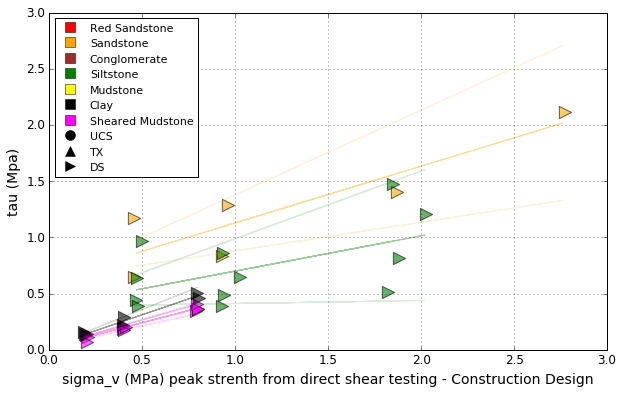

In [684]:
# p-q plot for sigma_c and tau data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'

statistics=[]

markers={'ucs':'o', 'tx':'^', 'ds':'>'} 

def legend():    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="magenta")
    sym10 = Line2D([0], [0], linestyle="none", marker="o", alpha=1.0, markersize=10, color="black")
    sym11 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym12 = Line2D([0], [0], linestyle="none", marker=">", alpha=1.0, markersize=10, color="black")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym10,sym11,sym12),
           ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone",
            "UCS","TX","DS"),fontsize=11, numpoints=1,loc="upper left")

def rand_jitter(arr):
    if not arr.any():
        pass
    else:
        stdev = .01*(max(arr)-min(arr))
        return arr + np.random.randn(len(arr)) * stdev

def pq_plot(sig1, sig3, lithology, test, sample_description):
# p-q plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    #if test=='ucs' or test=='tx':
    if test=='ucs':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    if test=='tx':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    if test=='ds':
        plt.scatter(rand_jitter(sig3_),rand_jitter(sig1_),
                    marker=markers[test],s= 150.,facecolor=colors[lithology],alpha=0.6)
        if not sig1_.any():  #if no data for lithology  --> mv this above plt.scatter                      #ToDo JK
            pass
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(sig3_,sig1_)
            line = slope*sig3_+intercept            
            line_upper = (slope+std_err*1.96)*sig3_+intercept
            line_lower = (slope-std_err*1.96)*sig3_+intercept
            plt.plot(sig3_,line, color=colors[lithology],alpha=0.4)
            plt.plot(sig3_,line_upper, color=colors[lithology],alpha=0.15)
            plt.plot(sig3_,line_lower, color=colors[lithology],alpha=0.15)
            #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

            statistics.append((lithology,
                              str(format(intercept,'.3f')),
                              str(format(degrees(atan(slope)),'.1f')),
                              str(format(degrees(atan(slope-std_err*1.96)),'.1f')),
                              str(format(degrees(atan(slope+std_err*1.96)),'.1f')),
                              str(format(std_err,'.2f')),
                              str(format(r_value,'.2f')),str(format(p_value,'.5f'))))
            
    plt.ylabel('q (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('p (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

plt.subplot(511)
plt.xlim((0,3))
plt.ylim((0,3))
for lithology in lithologies:
    pq_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
plt.ylabel('tau (Mpa)',fontsize=14)
plt.xlabel('sigma_v (MPa) peak strenth from direct shear testing - Construction Design',fontsize=14)
legend()    

plt.show()

In [685]:
# display derived parameters and statistics
statistics_df = pd.DataFrame(data=statistics)
statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                         u'std_err', u'correlation', u'p_value']
display(HTML('<h4>Derived c, phi and statistics of plotted values from direct shear testing - peak strength</h3>'))
display(HTML(statistics_df.to_html()))  

,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Sandstone,0.625,26.8,14.3,37.0,0.13,0.89,0.01660
1,Siltstone,0.385,17.5,1.5,31.1,0.15,0.56,0.05822
2,Sheared Mudstone,0.024,23.4,20.6,26.1,0.03,0.98,0.00000
3,Clay,0.028,29.5,25.3,33.4,0.05,0.99,0.00030


In [686]:
# query Data Organizer records for 'parameter' = tau
# sorting by borehole_code and sample_depth

# initialize variables
data_tau=[]

parameter = 'tau'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3    #ToDo JK

    if rec['measurement_convention'] == 'Residual strength':  #tmp - should handled in plot data              #ToDo JK
      data_tau.append(rec)
    
print('count for tau: '+str(len(data_tau)))    # record count for checking

count for tau: 18


In [687]:
# select sigma_c (uniaxial and triaxial compression) and tau (direct shear) values for selected lithologies
# sample_desciption is used to store construction phase (phase hould be added to parameter metadata)       #ToDo JK 

tests={'ucs':data_sigma_c,'tx':data_sigma_c,'ds':data_tau}  #test types and input data for each test type
test_names={'ucs':'Uniaxial compression','tx':'Triaxial compression','ds':'Direct shear'}  #for selecting test_type
lithologies=('Red Sandstone','Sandstone','Siltstone','Conglomerate','Mudstone','Sheared Mudstone','Clay')
sig1_const = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_const = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
sig1_basic = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
# Should all these not have to be in call to function?                                                     #ToDo JK

# select strength data from test results and write to dictionary
def selected_stengths(sample_description, sig1, sig3):
    for key,value in tests.items():  #loop over test types (=key)
        for lithology in lithologies:
            sig1[key][lithology]=[]  #initialize dictionary
            sig3[key][lithology]=[]  #initialize dictionary
        for rec in value:  #for each record of input data
            if (rec['test_type']) == test_names[key]: #select for test type 
                if (rec['value']) != 'NaN':  #ignore NaN values
                    if (rec['sample_description']) == sample_description:  #select for phase
                        for lithology in lithologies:  # select for lithology
                            if (rec['lithology']) == lithology:
                                sig1[key][lithology].append(float(rec['value']))
                                try: 
                                    float(rec['test_parameters']) 
                                    sig3[key][lithology].append(float(rec['test_parameters']))
                                except:
                                    sig3[key][lithology].append(float(0))  #set 'test_parameter' = 0 if missing
                                
selected_stengths('Construction Design', sig1_const, sig3_const) 
selected_stengths('Basic Design', sig1_basic, sig3_basic)            

def count_selected_stengths(sig1,description):  #counts for data checking
    for item in sig1: 
        count=0
        for lithology,value in sig1[item].items():
            item_len = len(sig1[item][lithology])
            count = count + item_len
            if item_len > 1:
                print(description+':   count for selected '+str(item)+' in '+str(lithology)+': '+str(item_len))
        print (description+': count for selected '+str(item)+': '+str(count)) 

count_selected_stengths(sig1_const,'Construction Design')
count_selected_stengths(sig1_basic,'Basic Design')

#print sig1_const['ucs']['Siltstone']
#print sig1_const['tx']
#print sig3_const['tx']

Construction Design:   count for selected ucs in Red Sandstone: 5
Construction Design:   count for selected ucs in Siltstone: 19
Construction Design: count for selected ucs: 24
Construction Design:   count for selected ds in Sheared Mudstone: 12
Construction Design:   count for selected ds in Clay: 6
Construction Design: count for selected ds: 18
Construction Design:   count for selected tx in Red Sandstone: 6
Construction Design:   count for selected tx in Siltstone: 6
Construction Design: count for selected tx: 12
Basic Design:   count for selected ucs in Sandstone: 6
Basic Design:   count for selected ucs in Siltstone: 6
Basic Design:   count for selected ucs in Conglomerate: 3
Basic Design: count for selected ucs: 15
Basic Design: count for selected ds: 0
Basic Design:   count for selected tx in Siltstone: 9
Basic Design: count for selected tx: 9


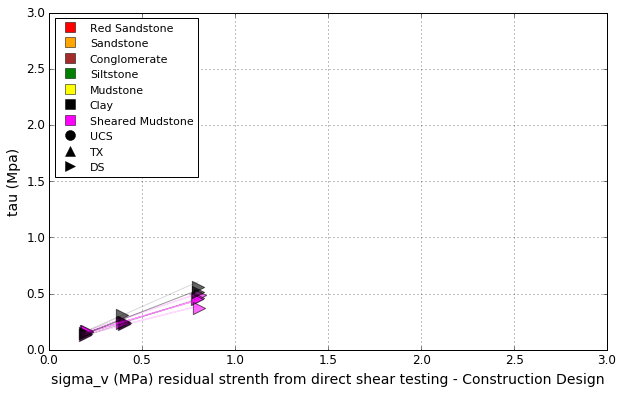

In [688]:
# p-q plot for sigma_c and tau data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'

statistics=[]

markers={'ucs':'o', 'tx':'^', 'ds':'>'} 

def legend():    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="magenta")
    sym10 = Line2D([0], [0], linestyle="none", marker="o", alpha=1.0, markersize=10, color="black")
    sym11 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym12 = Line2D([0], [0], linestyle="none", marker=">", alpha=1.0, markersize=10, color="black")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym10,sym11,sym12),
           ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone",
            "UCS","TX","DS"),fontsize=11, numpoints=1,loc="upper left")

def rand_jitter(arr):
    if not arr.any():
        pass
    else:
        stdev = .01*(max(arr)-min(arr))
        return arr + np.random.randn(len(arr)) * stdev

def pq_plot(sig1, sig3, lithology, test, sample_description):
# p-q plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    #if test=='ucs' or test=='tx':
    if test=='ucs':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    if test=='tx':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    if test=='ds':
        plt.scatter(rand_jitter(sig3_),rand_jitter(sig1_),
                    marker=markers[test],s= 150.,facecolor=colors[lithology],alpha=0.6)
        if not sig1_.any():  #if no data for lithology  --> mv this above plt.scatter                      #ToDo JK
            pass
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(sig3_,sig1_)
            line = slope*sig3_+intercept
            line_upper = (slope+std_err*1.96)*sig3_+intercept
            line_lower = (slope-std_err*1.96)*sig3_+intercept
            plt.plot(sig3_,line, color=colors[lithology],alpha=0.4)
            plt.plot(sig3_,line_upper, color=colors[lithology],alpha=0.15)
            plt.plot(sig3_,line_lower, color=colors[lithology],alpha=0.15)

            display(HTML(test+':  '+lithology+'  '+'cohesion intercept: '+str(format(intercept,'.3f'))
                    +'  friction slope: '+str(format(degrees(atan(slope)),'.1f'))
                    +'  friction slope lower: '+str(format(degrees(atan(slope-std_err*1.96)),'.1f'))
                    +'  friction slope upper: '+str(format(degrees(atan(slope+std_err*1.96)),'.1f'))
                    #95% confidence_interval = 1.96*std_err  #en.wikipedia.org/wiki/Confidence_interval#Basic_Steps
                    +'  std_err: '+str(format(std_err,'.2f'))  #standard error of the estimated slope
                    +'  r_value: '+str(format(r_value,'.2f'))  #correlation coefficient
                    +'  p_value: '+str(format(p_value,'.5f'))))#two-sided p-value for a hypothesis test whose 
                                                               #null hypothesis is that the slope is zero,using 
                                                               #Wald Test with t-distribution of the test statistic

            statistics.append((lithology,
                              str(format(intercept,'.3f')),
                              str(format(degrees(atan(slope)),'.1f')),
                              str(format(degrees(atan(slope-std_err*1.96)),'.1f')),
                              str(format(degrees(atan(slope+std_err*1.96)),'.1f')),
                              str(format(std_err,'.2f')),
                              str(format(r_value,'.2f')),str(format(p_value,'.5f'))))
             
    plt.ylabel('q (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('p (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

plt.subplot(511)
plt.xlim((0,3))
plt.ylim((0,3))
for lithology in lithologies:
    pq_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
plt.ylabel('tau (Mpa)',fontsize=14)
plt.xlabel('sigma_v (MPa) residual strenth from direct shear testing - Construction Design',fontsize=14)
legend()    

plt.show()

In [689]:
# display derived parameters and statistics
statistics_df = pd.DataFrame(data=statistics)
statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                         u'std_err', u'correlation', u'p_value']
display(HTML('<h4>Derived c, phi and statistics of plotted values from direct shear testing - residual strength</h3>'))
display(HTML(statistics_df.to_html()))  

,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Sheared Mudstone,0.054,25.9,22.6,29.1,0.04,0.97,0.00000
1,Clay,0.018,32.7,28.8,36.3,0.05,0.99,0.00017


## Scatterplot of uniaxial testing data E50 vs sigma_c

In [690]:
# remove records for sigma_c if no record for E at the sample_depth, for scatterplot
# note: it is not checked here if E and sigma_c have valid data at borehole/sample_depth locations
# input: data_E, data_sigma_c

data_sigma_c_adj=[]  # adjusted lists containing uniaxial testing records
data_E_adj=[]
data_sigma_c_adj_loc=[] # adjusted lists containing borehole/sample_depth locations
data_E_adj_loc=[]

i=0

for item in data_sigma_c:
    if item['test_type'] == 'Uniaxial compression':
        data_sigma_c_adj.append(item)
        data_sigma_c_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
for item in data_E:
    if item['test_type'] == 'E measured during uniaxial compression':
        data_E_adj.append(item)
        data_E_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
            
data_check = set(data_sigma_c_adj_loc).intersection(data_E_adj_loc)  #unique pairs of intersection of lists
        
# quick list of borehole/sample detpoh data records in data_sigma_c that are also in data_E:
    # check if a record exists with an E value at the sample_depth of the item
    # and append to the adjusted list if record exists 
    #if any(d['sample_depth_top_m'] == (data_sigma_c[i]['sample_depth_top_m']) for d in data_E):
    #    #print data_sigma_c[i]['borehole_code']
    #    #add if test_type = 'Uniaxial compression' (and add similar adjustment for E)                 #ToDo  JK
    #    data_sigma_c_adj.append(item)
    #    i+=1
    #else:
    #    i=1+i
    #    pass

# check record counts
print(len(data_sigma_c))
print(len(data_sigma_c_adj))
print(len(data_E))
print(len(data_E_adj))

60
39
54
39


In [691]:
# testing of data sets used for scatterplot
data_check = set(data_sigma_c_adj_loc).intersection(data_E_adj_loc)  #unique pairs of intersection of lists
print 'data_check:',len(data_check)
set(data_sigma_c_adj_loc) & set(data_E_adj_loc)
print 'length: intersection of both data sets:',len(set(data_sigma_c_adj_loc) & set(data_E_adj_loc))
[name for name in data_sigma_c_adj_loc if name in data_E_adj_loc]
print 'legnth: if name in both data sets', len([name for name in data_sigma_c_adj_loc if name in data_E_adj_loc])
print 'difference between data sets', set(data_sigma_c_adj_loc).difference(data_E_adj_loc)

data_check: 32
length: intersection of both data sets: 32
legnth: if name in both data sets 39
difference between data sets set([])


In [692]:
# display record of scatterplot data
# input: data_E_adj, data_sigma_c_adj
data_scatterplot=[]
for i in range(len(data_E_adj)):
    data_scatterplot.append((data_sigma_c_adj[i]['borehole_code'],data_sigma_c_adj[i]['sample_depth_top_m'],
          float(data_E_adj[i]['value']), float(data_sigma_c_adj[i]['value']),
          '{0:.0f}'.format(float(data_E_adj[i]['value'])/float(data_sigma_c_adj[i]['value'])),
          data_E_adj[i]['sample_description'],data_E_adj[i]['lithology']))
data_scatterplot_df = pd.DataFrame(data=data_scatterplot)
data_scatterplot_df.columns = [u'Borehole',u'Depth',u'E (MPa)',u'sigma_c (MPa)',u'Ratio E/sigma_c',
                               u'Sample',u'Lithology', ]
display(HTML('<h4>Selected data for scatterplot </h4>'))
display(HTML(data_scatterplot_df.to_html()))

,Borehole,Depth,E (MPa),sigma_c (MPa),Ratio E/sigma_c,Sample,Lithology
0,NT1-1,27.10,3352.0,86.82,39,Basic Design,Conglomerate
1,NT1-1,61.50,3532.0,75.15,47,Basic Design,Conglomerate
2,NT1-11,15.65,3142.0,85.02,37,Basic Design,Sandstone
3,NT1-14,28.90,13200.0,56.01,236,Construction Design,Red Sandstone
4,NT1-14,36.80,51400.0,106.68,482,Construction Design,Red Sandstone
5,NT1-14,37.30,19700.0,78.68,250,Construction Design,Red Sandstone
6,NT1-14,37.30,17800.0,126.68,141,Construction Design,Red Sandstone
7,NT1-14,56.80,22100.0,105.35,210,Construction Design,Red Sandstone
8,NT1-15,32.20,4170.0,20.67,202,Construction Design,Siltstone
9,NT1-18,23.50,6760.0,22.04,307,Construction Design,Siltstone


Construction Design  Red Sandstone  intercept: 78.6496748636  slope: 0.000645343201949  error: 0.000977202185604
Construction Design  Siltstone  intercept: 29.4019812325  slope: 0.000148053947  error: 0.000588170738255
Basic Design  Sandstone  intercept: -19.8662446983  slope: 0.0292835384507  error: 0.006519656444
Basic Design  Siltstone  intercept: -5.94147895119  slope: 0.0213943151862  error: 0.0137015869259
Basic Design  Conglomerate  intercept: 7.7399767573  slope: 0.0214194812572  error: 0.0092536016139


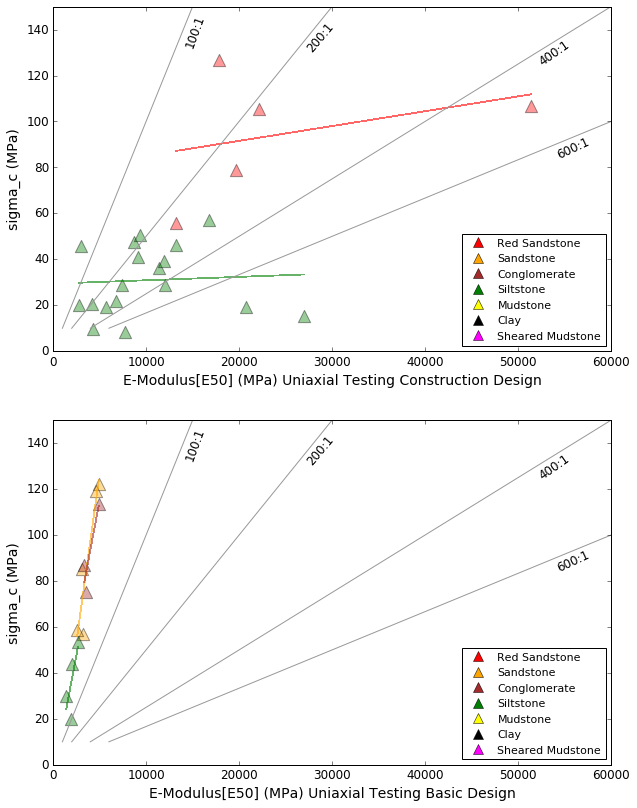

In [693]:
# scatterplot of E50 against sigma_c for all rock lithologies
# input: data_E_adj, data_sigma_c_adj containing ordered 'values' of 'parameter' E and sigma_c,
#        ordering using 'borehole_code' and sample_depth_top_m
# prcocedure needs to berobust, check that correct ordered pairs are always plotted                       #ToDo JK

# lithologies: defined above 
E={}
sigma_c={}

# select E, sgima_c data pairs and write to dictionary
# select for construction phase implies that E and sigma_c values are both in same phase, correct?        #ToDo JK
def selected_pairs(sample_description):
    E.clear()
    sigma_c.clear()
    for lithology in lithologies:
        E[lithology]=[]  #initialize dictionary
        sigma_c[lithology]=[]  #initialize dictionary
    for i in range(len(data_E_adj)):
        if (data_E_adj[i]['value']) != 'NaN':  #ignore NaN values    
            if (data_E_adj[i]['sample_description']) == sample_description:  #select for phase
                for lithology in lithologies:  # select for lithology
                    if (data_E_adj[i]['lithology']) == lithology:
                        if float(data_E_adj[i]['value']):  #this is only check for E, not sigma_c         #ToDo JK
                            E[lithology].append(float(data_E_adj[i]['value']))
                            sigma_c[lithology].append(float(data_sigma_c_adj[i]['value']))

def scatter_plot(E_, sigma_c_, lithology, sample_description):
    if E_.any():  # if E values are present for a selected lithology
        # scatterplot for values of selected lithology
        plt.scatter(E_,sigma_c_,
                    marker='^',s= 150.,facecolor=colors[lithology],alpha=0.4)
        #calculate linear regression
        line=(); s1=(); s3=(); intercept=0.; slope=0.; std_err=0.
        slope, intercept, r_value, p_value, std_err = stats.linregress(E_,sigma_c_)
        line = slope*E_+intercept
        plt.plot(E_,line, color=colors[lithology],alpha=0.6,linewidth=0.8,antialiased=False)
        print(sample_description+'  '+lithology+'  '+
              'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

def legend():    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="magenta")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7),
           ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone"),
             fontsize=11, numpoints=1,loc="lower right")

def trend():
# show a reference trend line
    plt.plot((1000,10000,20000,30000),(10,100,200,300),color='0.6')
    plt.annotate("100:1",xy=(14000,143),xytext=(14000,143),rotation=70,fontsize=12)
    plt.plot((2000,20000,40000,60000),(10,100,200,300),color='0.6')
    plt.annotate("200:1",xy=(27000,140),xytext=(27000,140),rotation=50,fontsize=12)
    plt.plot((4000,40000,60000),(10,100,150),color='0.6')
    plt.annotate("400:1",xy=(52000,132),xytext=(52000,132),rotation=35,fontsize=12)
    plt.plot((6000,60000),(10,100),color='0.6')
    plt.annotate("600:1",xy=(54000,90),xytext=(54000,90),rotation=25,fontsize=12)


plt.figure(figsize=(10, 21))

plt.subplot(311)
selected_pairs('Construction Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Construction Design')
    
plt.xlim((0,60000))
plt.ylim((0,150))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Uniaxial Testing Construction Design',fontsize=14)
trend()
legend()
# check plot values
#print E
#print sigma_c

plt.subplot(312)
selected_pairs('Basic Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Basic Design')

plt.xlim((0,60000))
plt.ylim((0,150))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Uniaxial Testing Basic Design',fontsize=14)
trend()
legend()
# check plot values
#print E
#print sigma_c

plt.show()

## Scatterplot of triaxial testing data E50 vs sigma_c

In [694]:
# remove records for sigma_c if no record for E at the sample_depth, for scatterplot
# note: it is not checked here if E and sigma_c have valid data at borehole/sample_depth locations
# input: data_E, data_sigma_c (ordered by borehole and sample depth)

data_sigma_c_adj=[]  # adjusted list with dictionaries containing triaxial testing records
data_E_adj=[]
data_sigma_c_adj_loc=[] # adjusted lists containing borehole/sample_depth locations
data_E_adj_loc=[]

i=0

# list with depth data records for data_sigma_c and data_E (presumes same reocord count for each data)
for item in data_sigma_c:
    if item['test_type'] == 'Triaxial compression':
        data_sigma_c_adj.append(item)
        data_sigma_c_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
for item in data_E:
    if item['test_type'] == 'E measured during triaxial compression':
        data_E_adj.append(item)
        data_E_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
            
data_check = set(data_sigma_c_adj_loc).intersection(data_E_adj_loc)  #unique pairs of intersection of lists
        
# list of borehole/sample depth data records in data_sigma_c that are also in data_E:
    # check if a record exists with an E value at the sample_depth of the item
    # and append to the adjusted list if record exists 
    #if any(d['sample_depth_top_m'] == (data_sigma_c[i]['sample_depth_top_m']) for d in data_E):
    #    #print data_sigma_c[i]['borehole_code']
    #    #add if test_type = 'Triaxial compression' (and add similar adjustment for E)                 #ToDo  JK
    #    data_sigma_c_adj.append(item)
    #    i+=1
    #else:
    #    i=1+i
    #    pass

# check record counts
print(len(data_sigma_c))
print(len(data_sigma_c_adj))
print(len(data_E))
print(len(data_E_adj))

60
21
54
15


In [695]:
# testing of data sets used for scatterplot
data_check = set(data_sigma_c_adj_loc).intersection(data_E_adj_loc)  #unique pairs of intersection of lists
print 'data_check:',len(data_check)
set(data_sigma_c_adj_loc) & set(data_E_adj_loc)
print 'length: intersection of both data sets:',len(set(data_sigma_c_adj_loc) & set(data_E_adj_loc))
[name for name in data_sigma_c_adj_loc if name in data_E_adj_loc]
print 'legnth: if name in both data sets', len([name for name in data_sigma_c_adj_loc if name in data_E_adj_loc])
print 'difference between data sets', set(data_sigma_c_adj_loc).difference(data_E_adj_loc)

data_check: 4
length: intersection of both data sets: 4
legnth: if name in both data sets 15
difference between data sets set([(u'NT1-14', u'57.85'), (u'NT1-14', u'28.90')])


In [696]:
# display record of scatterplot data
# input: data_E_adj, data_sigma_c_adj
data_scatterplot=[]
for i in range(len(data_E_adj)):
    data_scatterplot.append((data_sigma_c_adj[i]['borehole_code'],data_sigma_c_adj[i]['sample_depth_top_m'],
          float(data_E_adj[i]['value']), float(data_sigma_c_adj[i]['value']),
          '{0:.0f}'.format(float(data_E_adj[i]['value'])/float(data_sigma_c_adj[i]['value'])),
          data_E_adj[i]['sample_description'],data_E_adj[i]['lithology']))
data_scatterplot_df = pd.DataFrame(data=data_scatterplot)
data_scatterplot_df.columns = [u'Borehole',u'Depth',u'E (MPa)',u'sigma_c (MPa)',u'Ratio E/sigma_c',
                               u'Sample',u'Lithology', ]
display(HTML('<h4>Selected data for scatterplot </h4>'))
display(HTML(data_scatterplot_df.to_html()))

,Borehole,Depth,E (MPa),sigma_c (MPa),Ratio E/sigma_c,Sample,Lithology
0,NT1-14,28.90,6867.0,127.17,54,Construction Design,Siltstone
1,NT1-14,28.90,11800.0,128.55,92,Construction Design,Siltstone
2,NT1-14,28.90,9579.0,90.54,106,Construction Design,Siltstone
3,NT1-14,57.85,11660.0,87.08,134,Construction Design,Siltstone
4,NT1-14,57.85,8640.0,63.58,136,Construction Design,Siltstone
5,NT1-14,57.85,11510.0,106.43,108,Construction Design,Siltstone
6,NT1-15,36.08,2200.0,74.64,29,Basic Design,Siltstone
7,NT1-15,36.08,2000.0,80.17,25,Basic Design,Siltstone
8,NT1-15,36.08,1000.0,52.53,19,Basic Design,Siltstone
9,NT1-19,58.60,2300.0,69.11,33,Basic Design,Siltstone


Construction Design  Siltstone  intercept: 96.5725111859  slope: 0.00039821055156  error: 0.00627880214771
Basic Design  Siltstone  intercept: 58.0172705018  slope: -0.0017405752754  error: 0.0152206106348


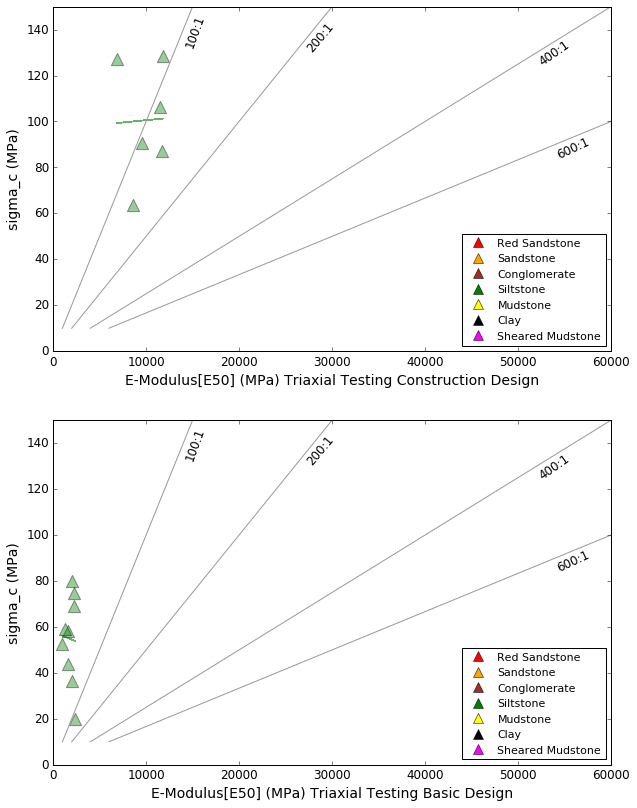

In [697]:
# scatterplot of E50 against sigma_c for all rock lithologies
# input: data_E_adj, data_sigma_c_adj containing ordered 'values' of 'parameter' E and sigma_c,
#        ordering using 'borehole_code' and sample_depth_top_m
# prcocedure needs to be robust, check that correct ordered pairs are always plotted                       #ToDo JK

# lithologies: defined above 
E={}
sigma_c={}

# select E, sgima_c data pairs and write to dictionary
# select for construction phase implies that E and sigma_c values are both in same phase, correct?        #ToDo JK
def selected_pairs(sample_description):
    E.clear()
    sigma_c.clear()
    for lithology in lithologies:
        E[lithology]=[]  #initialize dictionary
        sigma_c[lithology]=[]  #initialize dictionary
    for i in range(len(data_E_adj)):
        if (data_E_adj[i]['value']) != 'NaN':  #ignore NaN values    
            if (data_E_adj[i]['sample_description']) == sample_description:  #select for phase
                for lithology in lithologies:  # select for lithology
                    if (data_E_adj[i]['lithology']) == lithology:
                        if float(data_E_adj[i]['value']):  #this is only check for E, not sigma_c         #ToDo JK
                            E[lithology].append(float(data_E_adj[i]['value']))
                            sigma_c[lithology].append(float(data_sigma_c_adj[i]['value']))

def scatter_plot(E_, sigma_c_, lithology, sample_description):
    if E_.any():  # if E values are present for a selected lithology
        # scatterplot for values of selected lithology
        plt.scatter(E_,sigma_c_,
                    marker='^',s= 150.,facecolor=colors[lithology],alpha=0.4)
        #calculate linear regression
        line=(); s1=(); s3=(); intercept=0.; slope=0.; std_err=0.
        slope, intercept, r_value, p_value, std_err = stats.linregress(E_,sigma_c_)
        line = slope*E_+intercept
        plt.plot(E_,line, color=colors[lithology],alpha=0.6,linewidth=0.8,antialiased=False)
        print(sample_description+'  '+lithology+'  '+
              'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

def legend():    
# legend
    sym1 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="red")
    sym2 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="brown")
    sym4 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="yellow")
    sym6 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym7 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="magenta")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7),
               ("Red Sandstone","Sandstone","Conglomerate","Siltstone","Mudstone","Clay","Sheared Mudstone"),
                 fontsize=11, numpoints=1,loc="lower right")

def trend():
# show a reference trend line
    plt.plot((1000,10000,20000,30000),(10,100,200,300),color='0.6')
    plt.annotate("100:1",xy=(14000,143),xytext=(14000,143),rotation=70,fontsize=12)
    plt.plot((2000,20000,40000,60000),(10,100,200,300),color='0.6')
    plt.annotate("200:1",xy=(27000,140),xytext=(27000,140),rotation=50,fontsize=12)
    plt.plot((4000,40000,60000),(10,100,150),color='0.6')
    plt.annotate("400:1",xy=(52000,132),xytext=(52000,132),rotation=35,fontsize=12)
    plt.plot((6000,60000),(10,100),color='0.6')
    plt.annotate("600:1",xy=(54000,90),xytext=(54000,90),rotation=25,fontsize=12)


plt.figure(figsize=(10, 21))

plt.subplot(311)
selected_pairs('Construction Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Construction Design')
    
plt.xlim((0,60000))
plt.ylim((0,150))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Triaxial Testing Construction Design',fontsize=14)
trend()
legend()
# check plot values
#print E
#print sigma_c

plt.subplot(312)
selected_pairs('Basic Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Basic Design')

plt.xlim((0,60000))
plt.ylim((0,150))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Triaxial Testing Basic Design',fontsize=14)
trend()
legend()
# check plot values
#print E
#print sigma_c

plt.show()